In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import os

In [36]:
#import dataframe: 
df = pd.read_csv("../data/raw/labeled_ecg.csv",dtype={"label": "str"})

In [37]:
df

,time_sec,ECG,PPG,label
0,0.000,0.008698,0.005493,0
1,0.001,0.008545,0.004883,0
2,0.002,0.008698,0.000610,0
3,0.003,0.008850,0.000305,0
4,0.004,0.008850,0.000610,0
...,...,...,...,...
899996,899.996,-0.016480,0.097961,3
899997,899.997,-0.015717,0.098267,3
899998,899.998,-0.014343,0.097656,3
899999,899.999,-0.012970,0.097656,3


In [38]:
df = df.rename(columns={"time_sec": "time"})
df

,time,ECG,PPG,label
0,0.000,0.008698,0.005493,0
1,0.001,0.008545,0.004883,0
2,0.002,0.008698,0.000610,0
3,0.003,0.008850,0.000305,0
4,0.004,0.008850,0.000610,0
...,...,...,...,...
899996,899.996,-0.016480,0.097961,3
899997,899.997,-0.015717,0.098267,3
899998,899.998,-0.014343,0.097656,3
899999,899.999,-0.012970,0.097656,3


In [39]:
df_subset = df[['time', 'ECG', 'PPG', 'label']].copy()


In [40]:
df_subset

,time,ECG,PPG,label
0,0.000,0.008698,0.005493,0
1,0.001,0.008545,0.004883,0
2,0.002,0.008698,0.000610,0
3,0.003,0.008850,0.000305,0
4,0.004,0.008850,0.000610,0
...,...,...,...,...
899996,899.996,-0.016480,0.097961,3
899997,899.997,-0.015717,0.098267,3
899998,899.998,-0.014343,0.097656,3
899999,899.999,-0.012970,0.097656,3


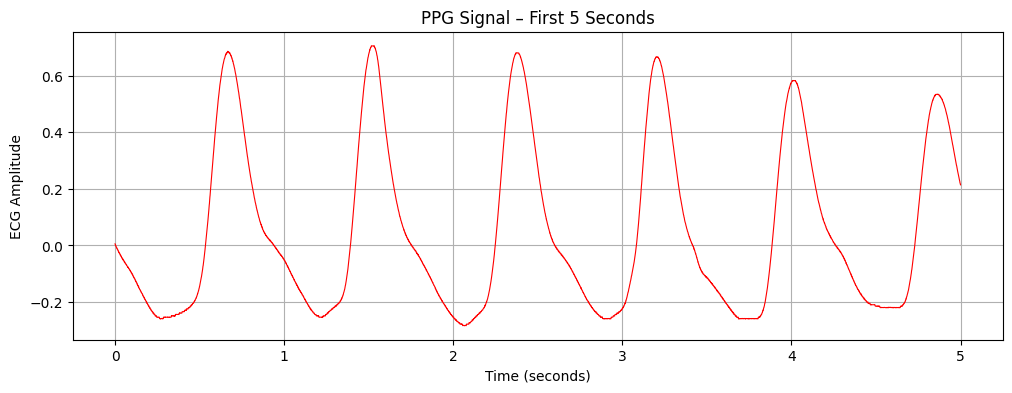

In [41]:
# Visualizing the one  minute ECG waveform
one_minute_df = df_subset[df_subset['time'] <= 5]
plt.figure(figsize=(12, 4))
plt.plot(one_minute_df['time'], one_minute_df['PPG'], color='red', linewidth=0.8)
plt.title("PPG Signal – First 5 Seconds")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Amplitude")
plt.grid(True)
plt.show()


In [42]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch

# Ensure label column is numeric (fix TypeError)
df_subset["label"] = pd.to_numeric(df_subset["label"], errors="coerce")

# Drop rows where label is NaN
df_subset = df_subset.dropna(subset=["label"])
df_subset["label"] = df_subset["label"].astype(int)

# Keep only valid labels 0,1,2,3
df_use = df_subset[df_subset["label"] >= 0].copy()


fs = 1000              # Hz
win_sec = 2            # 2-sec window
win_len = fs * win_sec # 2000 samples

signal = df_use["PPG"].values
labels_sample = df_use["label"].values     # 0,1,2,3 per sample
time_vals = df_use["time"].values          # time in seconds

features = []

# ---- 1. 2-second NON-OVERLAPPING windows ----
for start in range(0, len(signal) - win_len + 1, win_len):

    seg        = signal[start:start + win_len]
    seg_labels = labels_sample[start:start + win_len]
    seg_times  = time_vals[start:start + win_len]

    # ---------- TIME-DOMAIN ----------
    mean_ = np.mean(seg)
    var_  = np.var(seg)
    med_  = np.median(seg)
    skew_ = skew(seg)
    kurt_ = kurtosis(seg)
    zcr_  = np.sum(np.diff(np.sign(seg)) != 0) / win_len
    energy_ = np.sum(seg ** 2)

    # ---------- FREQUENCY-DOMAIN ----------
    freqs, psd = welch(seg, fs=fs, nperseg=win_len)
    total_power_ = np.trapezoid(psd, freqs)

    # ---------- TIME MID ----------
    t_mid = seg_times[win_len // 2]

    # ---------- WINDOW LABEL (FIXED) ----------
    # Majority label inside the window: 0,1,2,3
    win_label = pd.Series(seg_labels).value_counts().idxmax()

    features.append([
        t_mid, mean_, var_, med_, skew_, kurt_, zcr_, energy_, total_power_, win_label
    ])

df_features = pd.DataFrame(
    features,
    columns=[
        "time_mid", "mean", "variance", "median", "skewness",
        "kurtosis", "zcr", "energy", "total_power", "label"
    ]
)


In [43]:
df_features

,time_mid,mean,variance,median,skewness,kurtosis,zcr,energy,total_power,label
0,1.0,0.031084,8.514578e-02,-0.067749,1.037689,-0.192200,0.0045,172.223983,8.535424e-02,0
1,3.0,0.033000,9.421913e-02,-0.087280,0.835256,-0.711771,0.0035,190.616266,9.153897e-02,0
2,5.0,0.078171,5.757544e-02,0.044708,0.519693,-0.957261,0.0030,127.372406,5.971262e-02,0
3,7.0,0.046516,4.158573e-02,-0.028687,0.956532,-0.431307,0.0090,87.498972,3.829089e-02,0
4,9.0,0.035413,6.741357e-02,-0.058289,0.825089,-0.585567,0.0035,137.335292,7.115028e-02,0
...,...,...,...,...,...,...,...,...,...,...
445,891.0,0.083277,1.314078e-07,0.083313,-0.277390,0.438961,0.0000,13.870527,1.377749e-07,3
446,893.0,-0.011218,1.333854e+01,-0.838013,1.191608,0.490063,0.0005,26677.340538,1.102402e+01,3
447,895.0,0.110439,5.129655e-03,0.093079,0.142645,-0.974734,0.0005,34.652717,2.716679e-03,3
448,897.0,0.026060,4.589545e-06,0.025330,2.099191,3.900410,0.0000,1.367429,9.115437e-07,3


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

feature_cols = ["mean","variance","median","skewness",
                "kurtosis","zcr","energy","total_power"]

X = df_features[feature_cols].values
y_true = df_features["label"].values    # 0,1,2,3

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans with 4 clusters (since you want to look at all noise types)
kmeans = KMeans(n_clusters=4, random_state=42)
df_features["cluster"] = kmeans.fit_predict(X_scaled)


In [26]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans

# feature_cols = ["mean","variance","median","skewness",
#                 "kurtosis","zcr","energy","total_power"]

# X = df_features[feature_cols]

# #takes all rows and columns from column index 1 to the end. i.e mean until zero crossing rate.
# # X scaled = x-mean/sd to the all data features before using kmeans. i.e normalize before feeding into the K Mean
# scalar = StandardScaler()
# X_scaled = scalar.fit_transform(X)
# #Create 4 different cluster. 
# kmeans = KMeans(n_clusters=4, random_state=42)
# df_features["cluster"] = kmeans.fit_predict(X_scaled)
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(k_values, sil_values, marker="o", linestyle="-")
# plt.title("Silhouette Score vs Number of Clusters (k)")
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Silhouette Score")
# plt.grid(True)
# plt.xticks(k_values)
# plt.show()

In [64]:
fs = 1000                # sampling rate (Hz)
win_sec = 2
win_len = int(fs * win_sec)
step = win_len


df_features = df_features.copy()
df_features['start_idx'] = df_features.index * step
df_features['end_idx']   = df_features['start_idx'] + win_len


In [74]:
import numpy as np

signal = df_subset['PPG'].values
time   = df_subset['time'].values

cluster_id = 3
N = len(signal)

mask = np.zeros(N, dtype=bool)

for _, row in df_features[df_features['cluster'] == cluster_id].iterrows():
    s = int(row.start_idx)
    e = int(row.end_idx)
    mask[s:e] = True

# ECG samples belonging to this cluster
cluster_signal = np.where(mask, signal, np.nan)


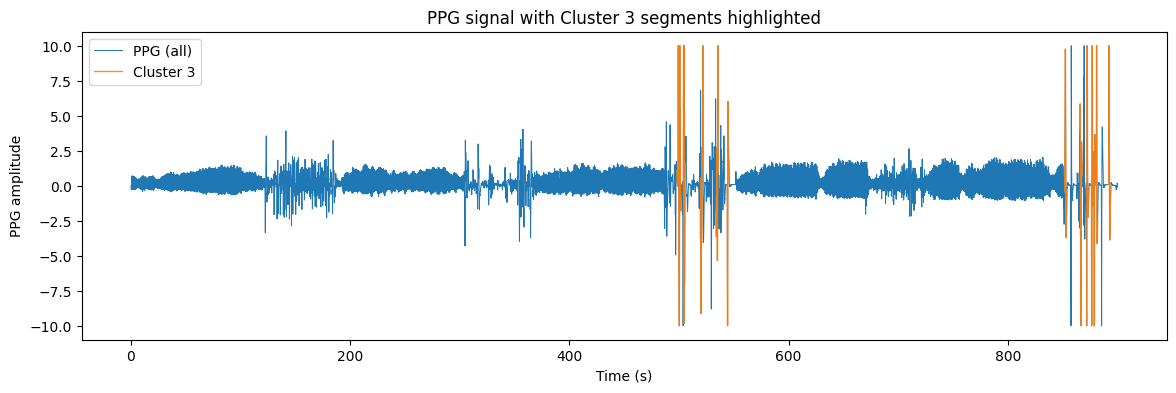

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(time, signal, linewidth=0.7, label='PPG (all)')
plt.plot(time, cluster_signal, linewidth=1.0, label=f'Cluster {cluster_id}', alpha=0.9)

plt.xlabel("Time (s)")
plt.ylabel("PPG amplitude")
plt.title(f"PPG signal with Cluster {cluster_id} segments highlighted")
plt.legend()
#path to save figure. 
save_dir = "../reports/figures/PPG"
# build file name
file_name = f"ppg_cluster_{cluster_id}.png"
save_path = os.path.join(save_dir, file_name)
# --- save figure ---
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # high-res export

plt.show()


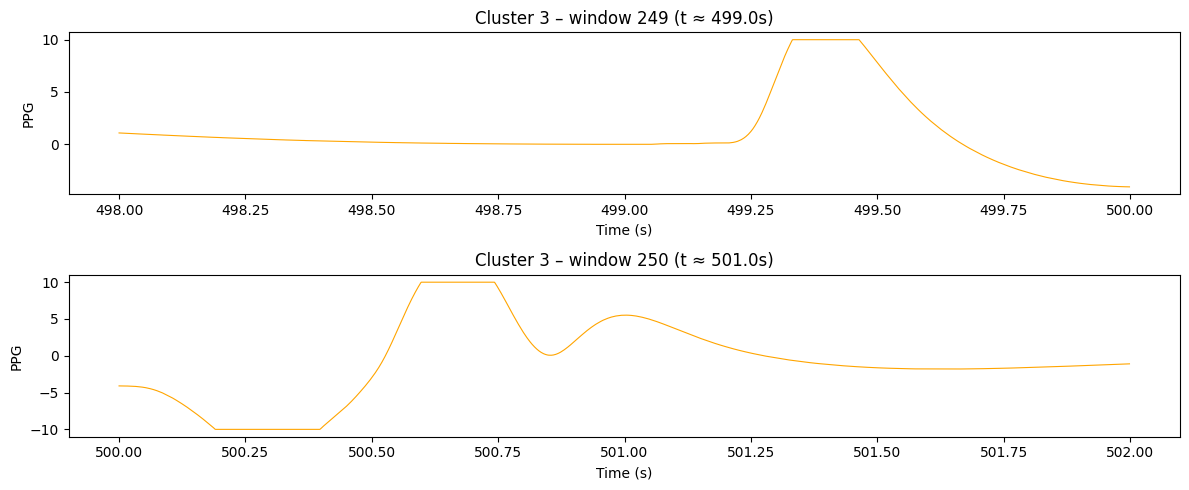

In [76]:
cluster_id = 3
cluster_windows = df_features[df_features['cluster'] == cluster_id].head(2)  # first 6 windows

rows = len(cluster_windows)
plt.figure(figsize=(12, 2.5 * rows))

for i, (_, row) in enumerate(cluster_windows.iterrows(), start=1):
    s = int(row.start_idx)
    e = int(row.end_idx)
    seg_t = time[s:e]
    seg_x = signal[s:e]

    plt.subplot(rows, 1, i)
    plt.plot(seg_t, seg_x, color='orange', linewidth=0.8)
    plt.title(f"Cluster {cluster_id} – window {int(row.name)} (t ≈ {row.time_mid:.1f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("PPG")

plt.tight_layout()
filename_window = f"ppg_window_{cluster_id}.png"
save_path = os.path.join(save_dir, filename_window)
# --- save figure ---
plt.savefig(save_path, dpi=300, bbox_inches='tight')  
plt.show()


In [88]:
# import seaborn as sns

# sns.pairplot(df_features, vars=['mean','variance','skewness','kurtosis','zcr'], hue='cluster', diag_kind='kde')
# plt.suptitle("Pairwise feature separation by cluster", y=1.02)
# plt.show()


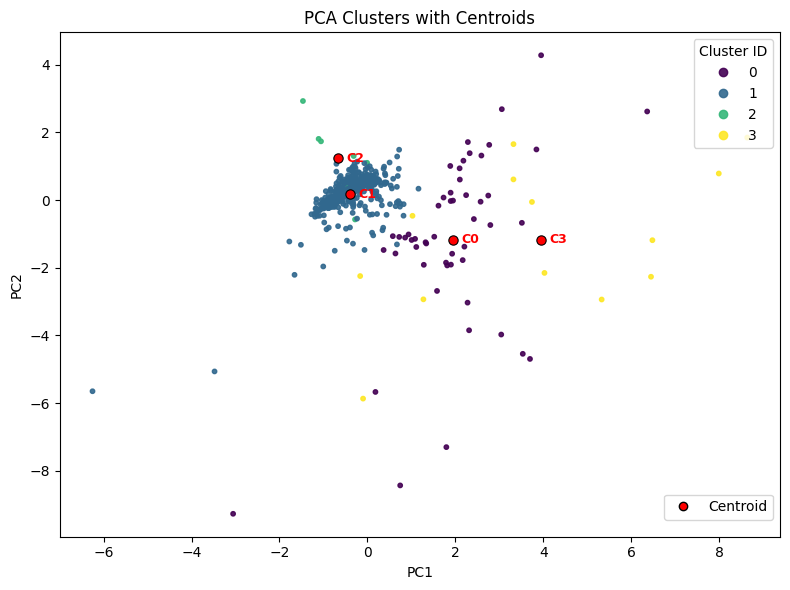

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# --- features & labels ---
feature_cols = ['mean','variance','median','skewness','kurtosis','zcr']
labels = df_features['cluster'].values
clusters = np.unique(labels)

# --- scale + PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features[feature_cols])

pca = PCA(n_components=2, random_state=42)
scores = pca.fit_transform(X_scaled)

# --- centroid in PCA space ---
centroids_2d = np.vstack([scores[labels == k].mean(axis=0) for k in clusters])

# --- scatter of cluster points ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(scores[:,0], scores[:,1],
                      c=labels, cmap='viridis', s=10, alpha=0.9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Clusters with Centroids')

# --- red circular centroids ---
plt.scatter(centroids_2d[:,0], centroids_2d[:,1],
            s=45, color='red', edgecolors='black', linewidths=0.8)

# --- label centroids slightly to the right ---
for k, (x, y) in zip(clusters, centroids_2d):
    plt.annotate(f"C{k}",
                 xy=(x, y),
                 xytext=(6, 0),              # shift right 6 points
                 textcoords='offset points',
                 fontsize=9, fontweight='bold',
                 color='red', va='center')

# --- cluster color legend (upper right) ---
cluster_handles, _ = scatter.legend_elements()
cluster_legend = plt.legend(cluster_handles,
                            [f"{i}" for i in np.unique(labels)],
                            title="Cluster ID",
                            loc="upper right")
plt.gca().add_artist(cluster_legend)

# --- centroid legend (bottom-right with padding) ---
centroid_handle = Line2D([0], [0], marker='o', color='w',
                         markerfacecolor='red', markeredgecolor='black',
                         markersize=6, linewidth=0, label='Centroid')

plt.legend(handles=[centroid_handle],
           loc='lower right',
           bbox_to_anchor=(1.0, 0.02),   # bottom-right, 20+ point padding below
           frameon=True, ncol=1)

plt.tight_layout()
filename_PCA = f"PCA_.png"
save_path = os.path.join(save_dir, filename_PCA)
# --- save figure ---
plt.savefig(save_path, dpi=300, bbox_inches='tight')  
plt.show()


In [79]:
#Mapping the cluster to ground truth
cluster_to_label = {}          
# cluster_to_label = {}   # dictionary to store mapping
for c in range(4):              # loop through clusters 0,1,2,3
    subset = df_features[df_features["cluster"] == c]
    # get all windows assigned to cluster c
    #check true labels inside the cluster
    most_common = subset["label"].value_counts().idxmax()
    # find which TRUE label appears most inside this cluster
    cluster_to_label[c] = most_common
    # save the mapping


In [80]:
#{cluster: noise_type}
#{0:"emg(Noise id:2)", 1:"clean(Noise id: 0)", 2:"sensor failure(noise id:3)", 3: Motion(noise id: 1)}
cluster_to_label

{0: np.int64(3), 1: np.int64(0), 2: np.int64(2), 3: np.int64(3)}

In [81]:
df_features["pred_label"] = df_features["cluster"].map(cluster_to_label)

y_pred = df_features["pred_label"].values


In [82]:
df_features

,time_mid,mean,variance,median,skewness,kurtosis,zcr,energy,total_power,label,cluster,start_idx,end_idx,pred_label
0,1.0,0.031084,8.514578e-02,-0.067749,1.037689,-0.192200,0.0045,172.223983,8.535424e-02,0,1,0,2000,0
1,3.0,0.033000,9.421913e-02,-0.087280,0.835256,-0.711771,0.0035,190.616266,9.153897e-02,0,1,2000,4000,0
2,5.0,0.078171,5.757544e-02,0.044708,0.519693,-0.957261,0.0030,127.372406,5.971262e-02,0,1,4000,6000,0
3,7.0,0.046516,4.158573e-02,-0.028687,0.956532,-0.431307,0.0090,87.498972,3.829089e-02,0,2,6000,8000,2
4,9.0,0.035413,6.741357e-02,-0.058289,0.825089,-0.585567,0.0035,137.335292,7.115028e-02,0,1,8000,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,891.0,0.083277,1.314078e-07,0.083313,-0.277390,0.438961,0.0000,13.870527,1.377749e-07,3,0,890000,892000,3
446,893.0,-0.011218,1.333854e+01,-0.838013,1.191608,0.490063,0.0005,26677.340538,1.102402e+01,3,3,892000,894000,3
447,895.0,0.110439,5.129655e-03,0.093079,0.142645,-0.974734,0.0005,34.652717,2.716679e-03,3,1,894000,896000,0
448,897.0,0.026060,4.589545e-06,0.025330,2.099191,3.900410,0.0000,1.367429,9.115437e-07,3,0,896000,898000,3


In [83]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
print("Multiclass confusion matrix (rows=true, cols=pred):\n", cm)

print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=3))


Multiclass confusion matrix (rows=true, cols=pred):
 [[289   0   2   9]
 [ 49   0   1  10]
 [ 20   0   3   7]
 [ 20   0   1  39]]

Classification report:
              precision    recall  f1-score   support

           0      0.765     0.963     0.853       300
           1      0.000     0.000     0.000        60
           2      0.429     0.100     0.162        30
           3      0.600     0.650     0.624        60

    accuracy                          0.736       450
   macro avg      0.448     0.428     0.410       450
weighted avg      0.618     0.736     0.662       450



/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

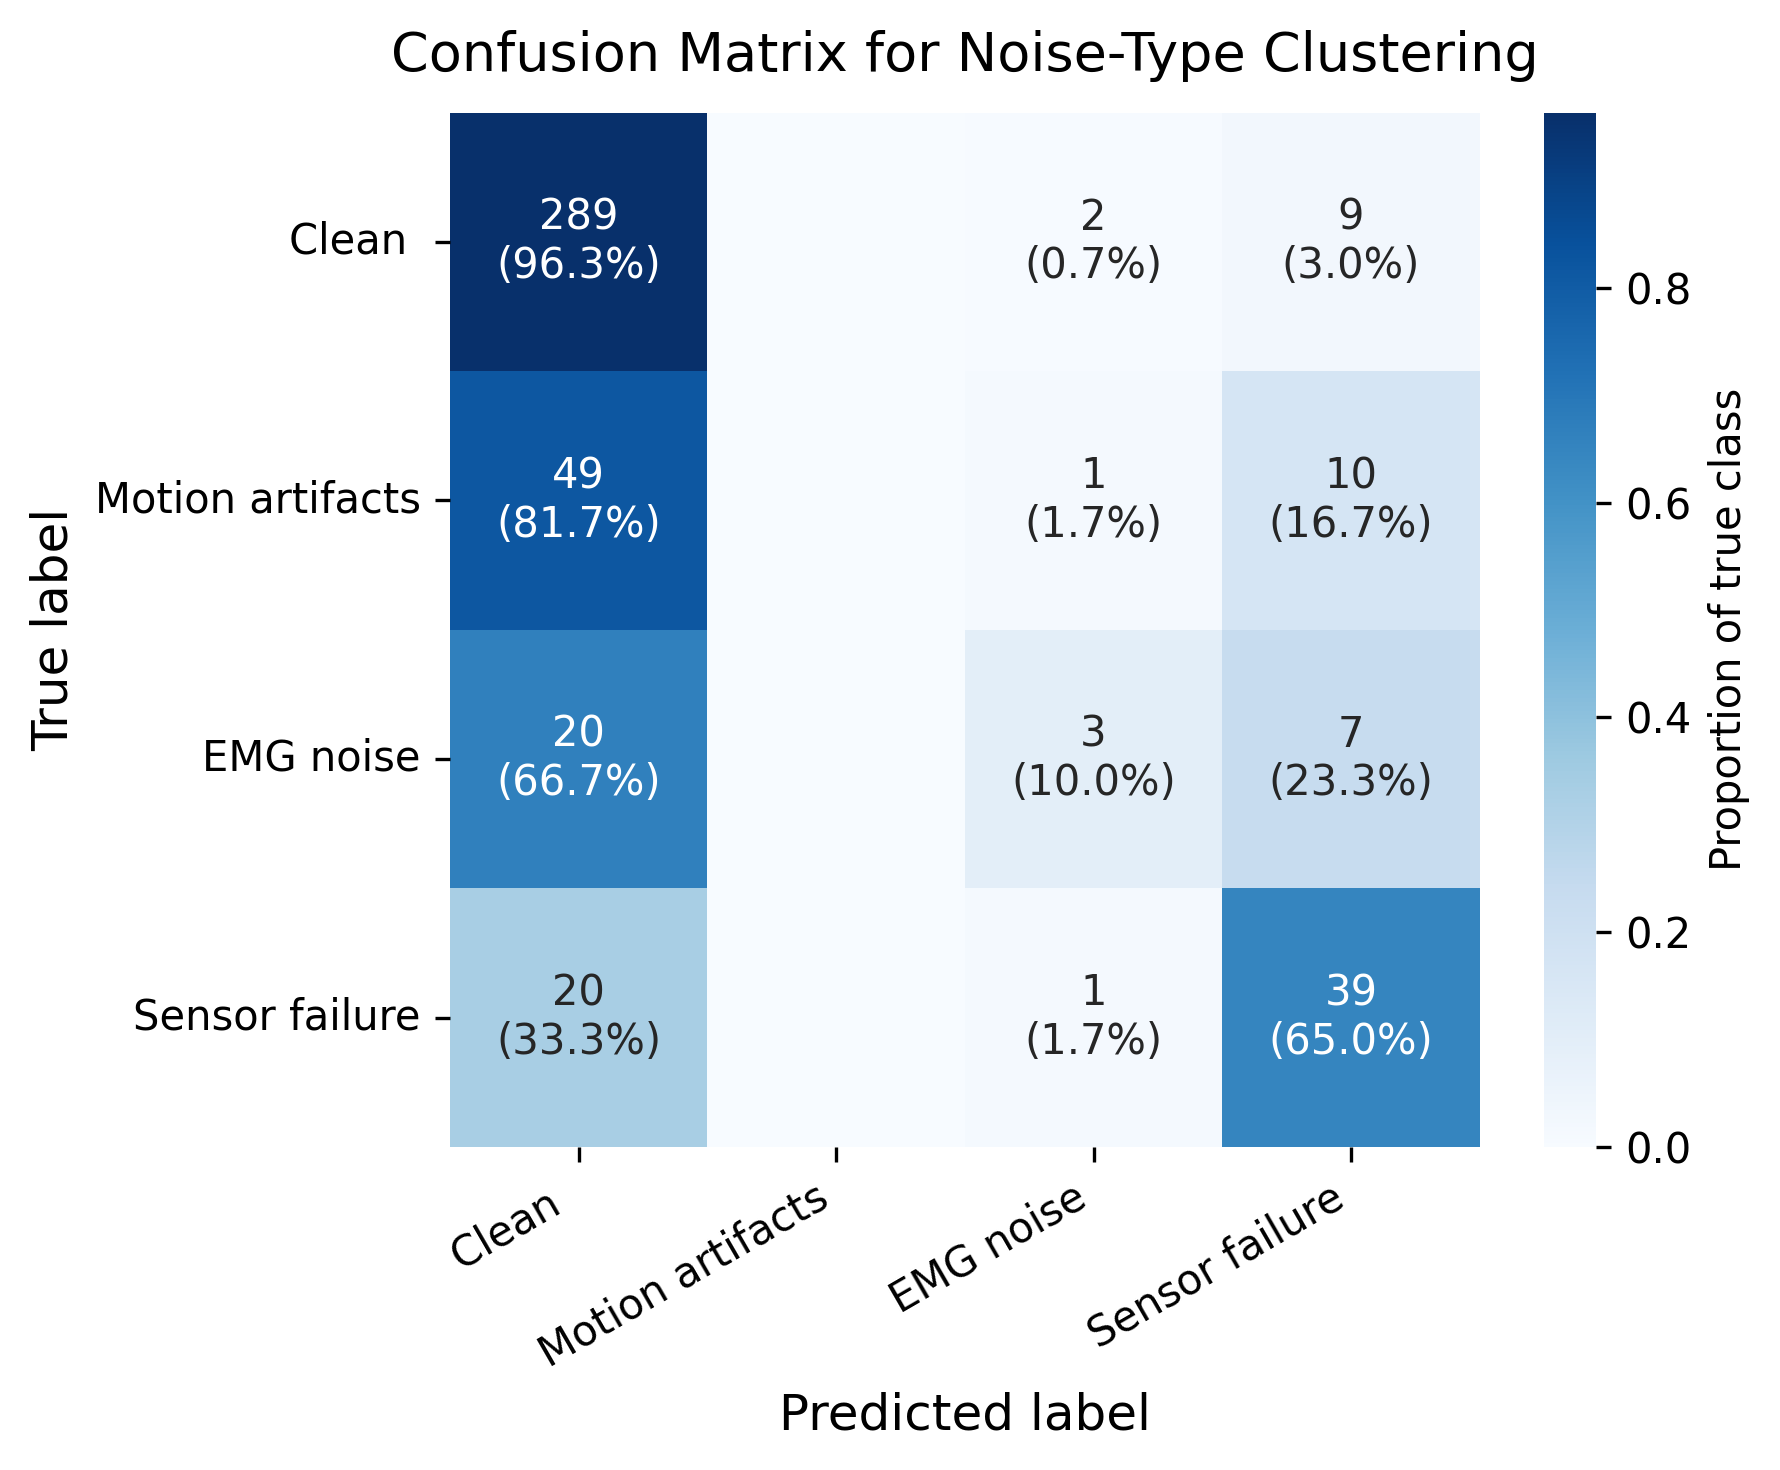

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. Compute confusion matrix ---
# order of labels (change names to match your classes)
label_order  = [0, 1, 2, 3]
class_names  = ["Clean ", "Motion artifacts", "EMG noise", "Sensor failure"]  # e.g. ["Clean","Motion","EMG","Sensor"]

cm = confusion_matrix(y_true, y_pred, labels=label_order)

# normalized by row (true class) → proportions
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# --- 2. Build annotation text: count + percentage ---
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_norm[i, j]
        if c == 0:
            annot[i, j] = ""
        else:
            annot[i, j] = f"{c}\n({p*100:.1f}%)"
            
# --- 3. Plot high-quality heatmap ---
plt.figure(figsize=(6, 5), dpi=300)

sns.heatmap(
    cm_norm,
    annot=annot,
    fmt="",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Proportion of true class"}
)

plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.title("Confusion Matrix for Noise-Type Clustering", fontsize=13, pad=10)

plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("PPG_confusion_matrix_noise_types.png", dpi=90, bbox_inches="tight")
plt.show()


/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sansri/Documents/Coursework/Fall_2026/ML/Clustering/clustering_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

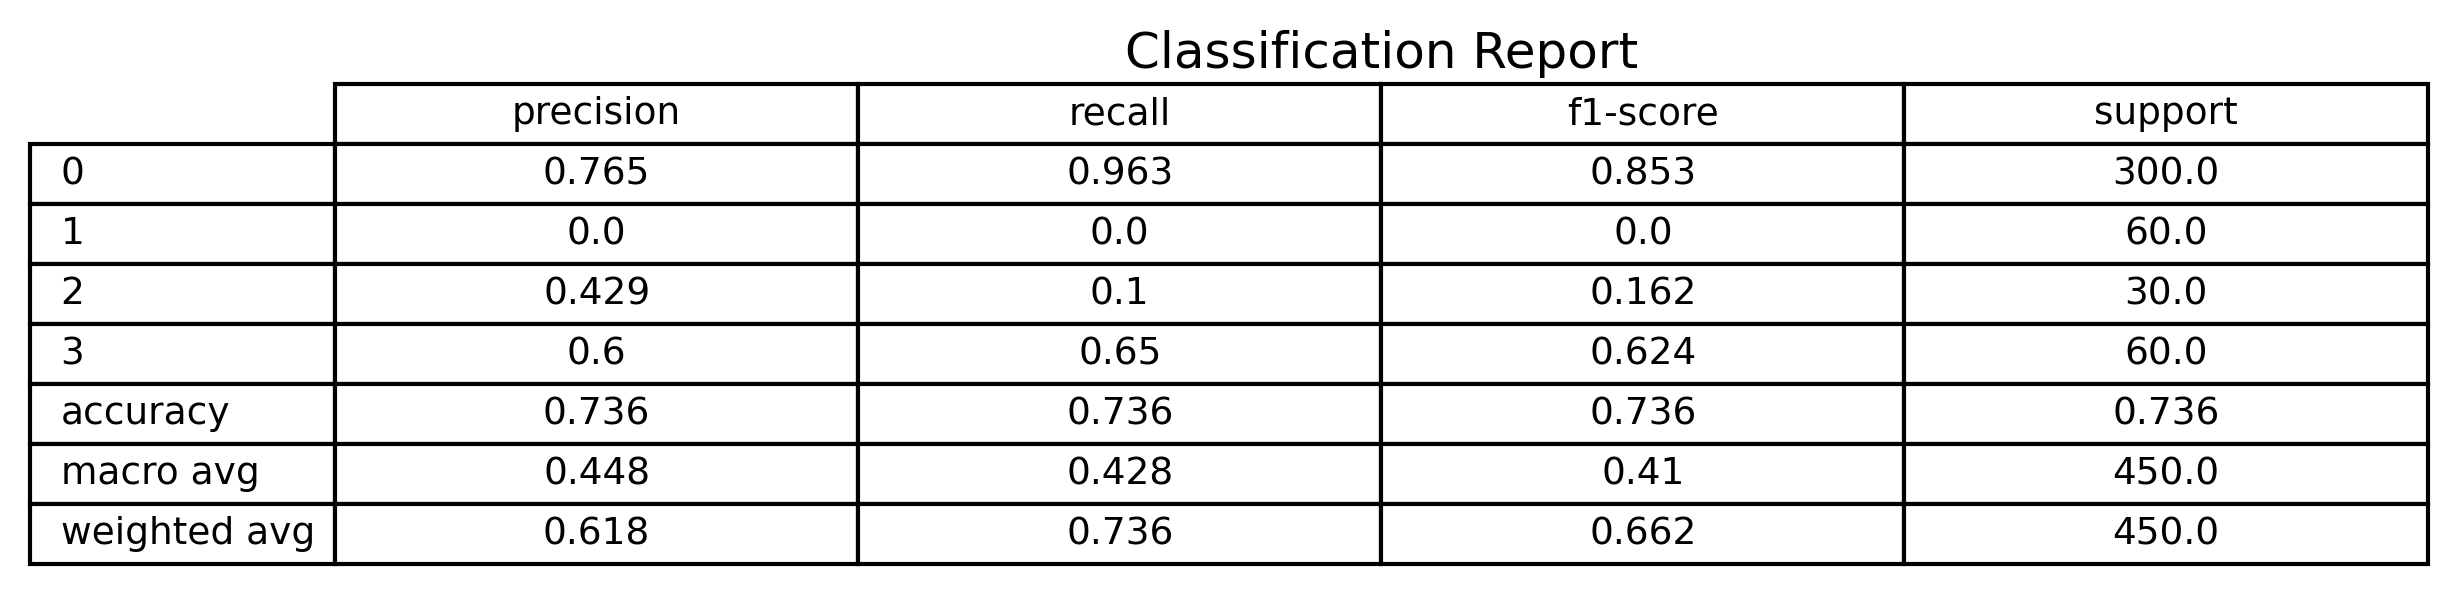

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

fig, ax = plt.subplots(figsize=(9, 2), dpi=300)

# Hide axes
ax.axis('off')
ax.axis('tight')

# Show table
table = ax.table(
    cellText=df.round(3).values,
    rowLabels=df.index,
    colLabels=df.columns,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.2)

plt.title("Classification Report", fontsize=12)
plt.savefig("PPG_classification_report_table.png", dpi=90, bbox_inches='tight')
plt.show()


In [89]:
y_true_bin = (y_true != 0).astype(int)       # 0=clean, 1=any noise
y_pred_bin = (y_pred != 0).astype(int)


In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm_bin = confusion_matrix(y_true_bin, y_pred_bin)
acc  = accuracy_score(y_true_bin, y_pred_bin)
prec = precision_score(y_true_bin, y_pred_bin)
rec  = recall_score(y_true_bin, y_pred_bin)
f1   = f1_score(y_true_bin, y_pred_bin)

print("Binary confusion matrix (clean vs any-noise):\n", cm_bin)
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")


Binary confusion matrix (clean vs any-noise):
 [[289  11]
 [ 89  61]]
Accuracy : 0.778
Precision: 0.847
Recall   : 0.407
F1-score : 0.550


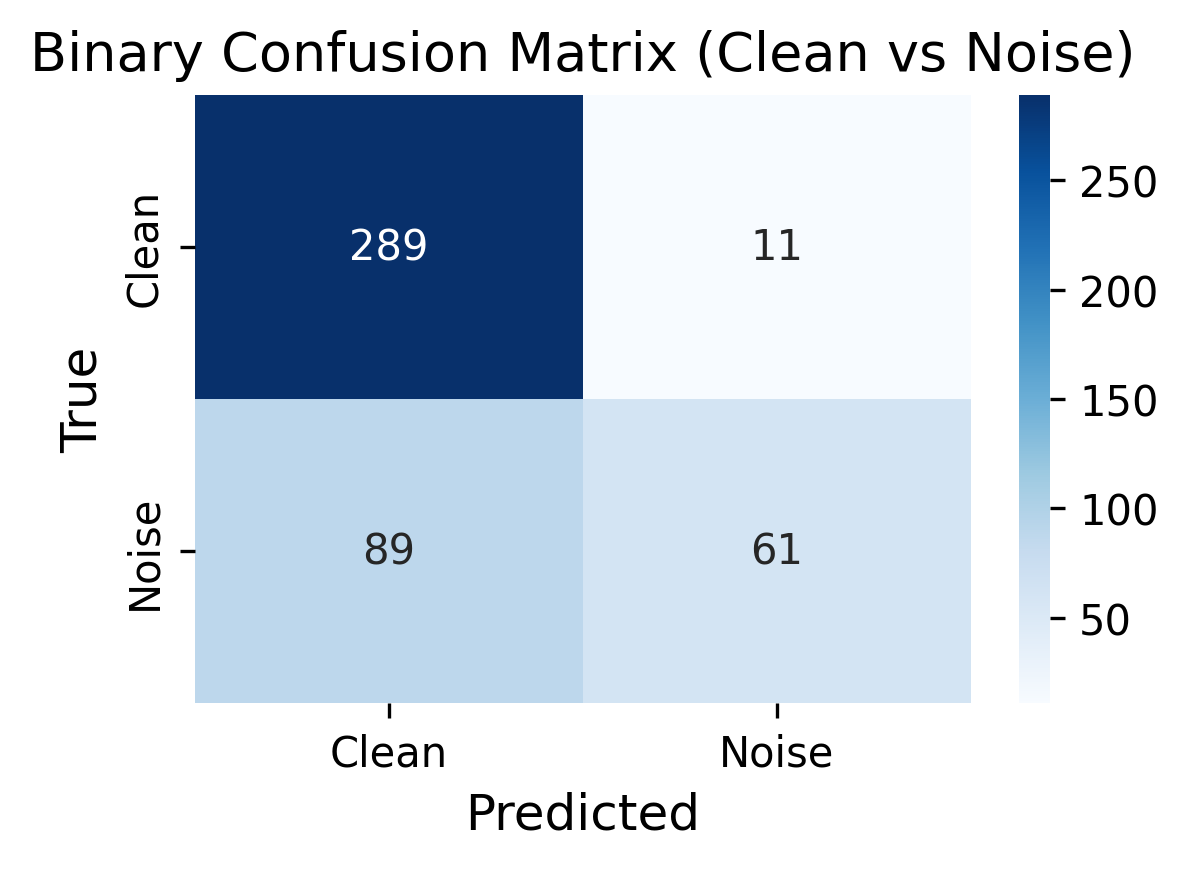

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# compute CM
cm_bin = confusion_matrix(y_true_bin, y_pred_bin)

# pretty labels
labels = ["Clean", "Noise"]

plt.figure(figsize=(4, 3), dpi=300)

sns.heatmap(
    cm_bin,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Binary Confusion Matrix (Clean vs Noise)", fontsize=13)
plt.tight_layout()
plt.savefig("PPG_binary_confusion_matrix.png", dpi=90)
plt.show()


In [302]:
results_by_type = []

for noise_type in [1, 2, 3]:
    mask = (y_true == noise_type)
    total = mask.sum()
    if total == 0:
        continue
    detected_as_noise = y_pred_bin[mask].sum()
    missed_as_clean   = total - detected_as_noise
    recall_type       = detected_as_noise / total

    results_by_type.append((noise_type, total, detected_as_noise, missed_as_clean, recall_type))

for (nt, total, detected, missed, rec_t) in results_by_type:
    print(f"Noise type {nt}: total={total}, "
          f"detected_as_noise={detected}, missed_as_clean={missed}, "
          f"recall={rec_t:.3f}")


Noise type 1: total=60, detected_as_noise=4, missed_as_clean=56, recall=0.067
Noise type 2: total=30, detected_as_noise=22, missed_as_clean=8, recall=0.733
Noise type 3: total=60, detected_as_noise=28, missed_as_clean=32, recall=0.467


In [136]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import silhouette_score

# # Select feature matrix
# X = StandardScaler().fit_transform(df_features.iloc[:, 1:])  # skip time_mid

# # Try hierarchical clustering
# agg = AgglomerativeClustering(
#     n_clusters=3,
#     linkage='ward'
# )

# labels_agg = agg.fit_predict(X)
# df_features['cluster_hier'] = labels_agg

# # Evaluate silhouette
# sil_agg = silhouette_score(X, labels_agg)
# print("Hierarchical Silhouette:", sil_agg)


In [105]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=0.9)   # keep 90% variance
# X_pca = pca.fit_transform(X)

# agg = AgglomerativeClustering(
#     n_clusters=3,
#     linkage='ward'
# )

# labels_agg = agg.fit_predict(X_pca)
# df_features['cluster_hier'] = labels_agg

# print("Hierarchical silhouette:", silhouette_score(X_pca, labels_agg))


Hierarchical silhouette: 0.3280259156040067


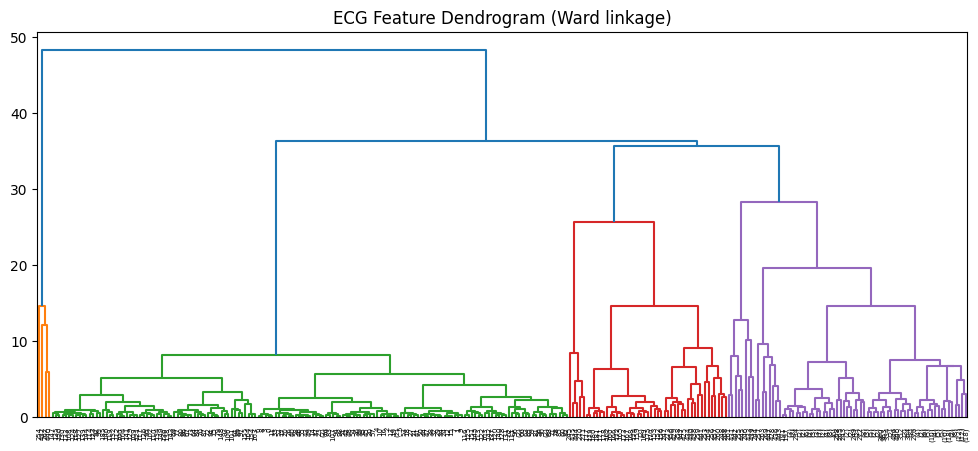

In [54]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# import matplotlib.pyplot as plt

# Z = linkage(X_pca, method='ward')

# plt.figure(figsize=(12, 5))
# dendrogram(Z, truncate_mode='level', p=10)
# plt.title("ECG Feature Dendrogram (Ward linkage)")
# plt.show()


In [137]:
# sil_kmeans = silhouette_score(X, kmeans.labels_)
# sil_hier = silhouette_score(X, labels_agg)

# print("K-means silhouette:", sil_kmeans)
# print("Hierarchical silhouette:", sil_hier)


In [164]:
#Evalution matrices::: 
df_features

,time_mid,mean,variance,median,skewness,kurtosis,zcr,energy,total_power,label,cluster,start_idx,end_idx
0,1.0,-0.009276,0.016237,0.001373,0.206414,1.990762,0.0075,32.646244,0.015272,1,1,0,2000
1,3.0,-0.018050,0.019228,-0.005569,-0.005160,0.706246,0.0075,39.108033,0.018262,1,1,2000,4000
2,5.0,-0.011732,0.014338,-0.001068,-0.021114,2.166420,0.0065,28.950788,0.016172,1,1,4000,6000
3,7.0,-0.009835,0.015648,0.001221,0.131484,1.765071,0.0075,31.490220,0.015429,1,1,6000,8000
4,9.0,-0.009422,0.014638,0.001526,-0.281516,0.881144,0.0085,29.453721,0.014141,1,1,8000,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,891.0,-0.025501,0.657293,0.020065,-0.629081,8.673805,0.0140,1315.886388,1.367062,1,0,890000,892000
446,893.0,-0.007528,0.000164,-0.010605,0.706552,0.362767,0.0155,0.441301,0.000096,1,1,892000,894000
447,895.0,-0.012872,0.000082,-0.013123,3.034980,20.851414,0.0035,0.495069,0.000022,1,1,894000,896000
448,897.0,-0.013906,0.000026,-0.013275,0.219520,0.412211,0.0010,0.438357,0.000031,1,1,896000,898000


In [168]:
#Cluter1: clean ECG  
#Cluster0 : Noisy ECG 

#Label1: Noisy ECG 
#Label0: Clean ECG
#marking the clean labels from data: 
y_true = df_features["label"].values        # 0 = clean, 1 = noise
y_pred = df_features["cluster"].values      # 1 = clean, 0 = noise



In [169]:
# cluster: inverts label clean: 0 and noise: 1 
y_pred = (df_features["cluster"] == 0).astype(int)


In [175]:
#Creating confusion matrix 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm


array([[  0,   0],
       [439,  11]])

In [172]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)


Accuracy : 0.024444444444444446
Precision: 1.0
Recall   : 0.024444444444444446
F1-score : 0.04772234273318872


In [173]:
import numpy as np

clean_cluster_purity = np.mean(y_true[df_features["cluster"] == 1] == 0)
noise_cluster_purity = np.mean(y_true[df_features["cluster"] == 0] == 1)

print("Clean cluster purity:", clean_cluster_purity)
print("Noise cluster purity:", noise_cluster_purity)


Clean cluster purity: 0.0
Noise cluster purity: 1.0


In [180]:
df_features

,time_mid,mean,variance,median,skewness,kurtosis,zcr,energy,total_power,label,cluster,start_idx,end_idx
0,1.0,-0.009276,0.016237,0.001373,0.206414,1.990762,0.0075,32.646244,0.015272,1,1,0,2000
1,3.0,-0.018050,0.019228,-0.005569,-0.005160,0.706246,0.0075,39.108033,0.018262,1,1,2000,4000
2,5.0,-0.011732,0.014338,-0.001068,-0.021114,2.166420,0.0065,28.950788,0.016172,1,1,4000,6000
3,7.0,-0.009835,0.015648,0.001221,0.131484,1.765071,0.0075,31.490220,0.015429,1,1,6000,8000
4,9.0,-0.009422,0.014638,0.001526,-0.281516,0.881144,0.0085,29.453721,0.014141,1,1,8000,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,891.0,-0.025501,0.657293,0.020065,-0.629081,8.673805,0.0140,1315.886388,1.367062,1,0,890000,892000
446,893.0,-0.007528,0.000164,-0.010605,0.706552,0.362767,0.0155,0.441301,0.000096,1,1,892000,894000
447,895.0,-0.012872,0.000082,-0.013123,3.034980,20.851414,0.0035,0.495069,0.000022,1,1,894000,896000
448,897.0,-0.013906,0.000026,-0.013275,0.219520,0.412211,0.0010,0.438357,0.000031,1,1,896000,898000
